In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, ForwardDiff, Optim
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature
# import Functors: @functor

## Prepare data 

In [3]:
function generate_data(n,x_0, f_gp, σ_x, σ_y)
    y=[]
    x = []
    obs = []
    x_prev = x_0
    for i=1:n
        x_t = σ_x * randn() 
        temp = x_t * exp(f_gp[i]) 
        push!(y,temp)
        push!(x,x_t)    
        push!(obs, temp + σ_y*randn())
    end
    return x, y , obs
end

generate_data (generic function with 1 method)

In [4]:
Random.seed!(1)

σ_x = 2pi/10 # true frequency
σ_y = 0.1 ## we assume low noise for now
x_init = 0.0

N = 300; #data length
n = 300; #length of the axis of gp 

## GP information
meanf = (x) -> 1.0;
kernel(θ) = 0.3*with_lengthscale(SqExponentialKernel(),θ)
tmin,tmax = 0., 5.0
time_range = collect(range(tmin, tmax; length=n));

θ_gp = 0.1 #true θ_gp

Cov_mat = kernelmatrix(kernel(θ_gp),time_range,time_range) + 1e-8*I;
gp = MvNormal(meanf.(time_range), Cov_mat)
f_test = rand(gp)

#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
f_train = f_test[pos];
cov_strategy = CovarianceMatrixStrategy(FullCovarianceStrategy())
# cov_strategy = CovarianceMatrixStrategy(FITC(90))

CovarianceMatrixStrategy{FullCovarianceStrategy{Vector{Int64}, Nothing}}(FullCovarianceStrategy{Vector{Int64}, Nothing}(Int64[], nothing, [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [5]:
#Generate data 
x_true_state,y_true_state,y_data = generate_data(N,x_init,f_train,σ_x,σ_y);

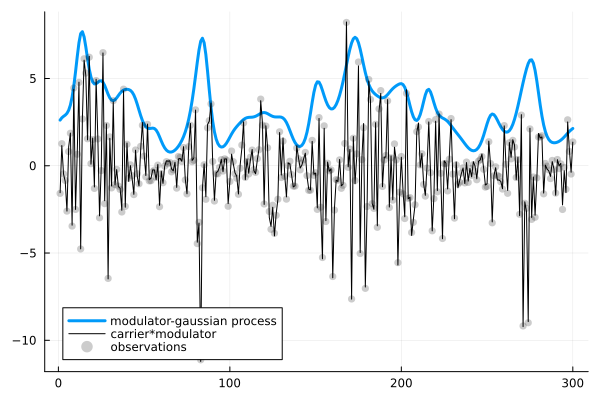

In [6]:
plot(exp.(f_train), label="modulator-gaussian process",linewidth=3.0)
plot!(y_true_state,label="carrier*modulator",color=:black)

scatter!(y_data, color=:black,label = "observations",alpha=0.2)

## Specify model

In [7]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output

In [8]:
### rule for y 
##TODO: this rule needs to be investigated for speed vs. accuracy 
@rule MyExponential(:y, Marginalisation) (m_x::GaussianProcess, meta::ProcessMeta) = begin
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
#     μ_in = m_gp[index]
#     @show index
#     var_in = cov_gp[index,index]
    kernelf = m_x.kernelfunction
    meanf   = m_x.meanfunction
    test    = m_x.testinput
    train   = m_x.traininput
    cov_strategy = m_x.covariance_strategy
    x_u = m_x.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    μ_in = mμ[1]
#     var_μ[1] < 0. ? var_in = 1 : var_in = var_μ[1]
    var_in = var_μ[1] #change here 
    return LogNormal(μ_in, var_in)
end

### rule for x
@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x))
    return ContinuousUnivariateLogPdf(log_pdf)
end

@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf,m_x::GaussianDistributionsFamily, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x)) + 1e-8
#     xsamples = rand(m_x, 10000)
#     weight   = exp.(log_pdf.(xsamples)) / sum(exp.(log_pdf.(xsamples)))
#     m_       = sum(weight .* xsamples)
#     v_       = sum(weight .* (xsamples .- m_).^2)
    
  
    
    meta = GaussHermiteCubature(121)
    m_,v_ = ReactiveMP.approximate_meancov(meta, z -> exp(log_pdf(z)), mean(m_x), var(m_x))
    ksi = m_/v_ - weightedmean(m_x)
    precision = clamp(1/v_ - precision(m_x),tiny,huge)
    
    
    return NormalWeightedMeanPrecision(ksi,precision)
end


@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, m_x::GaussianProcess, meta::ProcessMeta) = begin 
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
    kernelf = m_x.kernelfunction
    meanf   = m_x.meanfunction
    test    = m_x.testinput
    train   = m_x.traininput
    cov_strategy = m_x.covariance_strategy
    x_u = m_x.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    μ_in = mμ[1]
    var_μ[1] < 0. ? var_in = 1 : var_in = var_μ[1]
    
    log_pdf = (x) -> logpdf(m_y,exp(x)) + 1e-8

    
    meta = GaussHermiteCubature(121)
    m_,v_ = ReactiveMP.approximate_meancov(meta, z -> exp(log_pdf(z)), μ_in, var_in)
    
    
     
    ksi = m_/v_ - μ_in/var_in
    precision = clamp(1/v_ - 1/var_in,0.00001,100.0)
    
    return NormalWeightedMeanPrecision(ksi,precision)
end


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    return LogNormal(mean(m_x), var(m_x))
end
    
@rule MyExponential(:x, Marginalisation) (m_y::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    log_pdf = (x) -> logpdf(m_y,exp(x))
    return ContinuousUnivariateLogPdf(log_pdf)
end

In [9]:
#Test with GP with changeable hyperparameters
@model function gp_AmplitudeDemodulation(n, gp_kernel,gp_mean, train,test, gpstrategy)
    f = randomprocess(test, train, gpstrategy)
    y = datavar(Float64,n)
    g = randomvar(n)
    z = randomvar(n)

    θ ~ NormalMeanVariance(0.5, 50.)
    β ~ GammaShapeRate(0.01, 0.01)
    
    f ~ GaussianProcess(gp_mean, gp_kernel, θ) where {meta = CVI(StableRNG(42), 1000,100,ADAM(0.01))}
    for i=1:n 
        z[i] ~ NormalMeanPrecision(0.0,β)
        g[i] ~ MyExponential(f) where {meta = ProcessMeta(i)}
#         g[i] ~ MyExponential(f) where {meta = ProcessMeta(i),pipeline = RequireMessage(x = NormalMeanPrecision(1.0, 10.0))}
        
        y[i] ~ NormalMeanPrecision(g[i]*z[i], 1/σ_y^2)
    end
end

In [10]:
@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::Tuple, meta::TinyCorrection) = begin 
    μ_in = mean(m_in[1])
    var_in = mean(m_in[2])
    
    μ_out, var_out = mean_var(m_out)
    backwardpass = (x) -> -log(abs(x)+1e-8) - 0.5*log(2π * (var_in + var_out / x^2))  -1/2 * (μ_out / x - μ_in)^2 / (var_in + var_out / x^2)
    return ContinuousUnivariateLogPdf(backwardpass)
end

@rule typeof(*)(:in, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    μ_in, var_in = mean_var(m_A)
    μ_out, var_out = mean_var(m_out)
    backwardpass = (x) -> -log(abs(x)+1e-8) - 0.5*log(2π * (var_in + var_out / x^2))  - 1/2 * (μ_out / x - μ_in)^2 / (var_in + var_out / x^2)

    return ContinuousUnivariateLogPdf(backwardpass)
end



In [11]:
using Roots

## Rule for multiplication node

In [12]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(121)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)+1e-7), mean(left), var(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(121)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)+1e-7), mean(right), var(right))
    return NormalMeanVariance(m,v)
end

#Look carefully at these two functions 
function ReactiveMP.mean_var(p::ContinuousUnivariateLogPdf)
#     f = x -> ForwardDiff.derivative(p.logpdf,x) + 1e-7
#     m0 = find_zeros(f,-20,20)[1] #this function might return nothing if the range is too large
    res = optimize(x -> -logpdf(p,x),-50,50)
    m0 = res.minimizer
    meta = GaussHermiteCubature(221)
    v0 =  100.0
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(p.logpdf(z)-logpdf(NormalMeanVariance(m0,v0),z)), m0, v0)
    
    return m,v
end

Distributions.mean(p::ContinuousUnivariateLogPdf) = mean_var(p)[1]
Distributions.var(p::ContinuousUnivariateLogPdf) = mean_var(p)[2]


function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,10000)
    weights = [exp(logpdf(right,sample_left[i])+1e-8) for i=1:length(sample_left)]
    weight = weights / sum(weights)
    m = sum(weight .* log.(sample_left))
    v = sum(weight .* (log.(sample_left) .- m).^2)
    
#     μ = log(m^2/sqrt(m^2+v))
#     w = log(1+v/m^2)
    
    return LogNormal(m,v)
end

@rule NormalMeanVariance(:v, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanVariance(:v, Marginalisation) (q_out=d_out, q_μ=q_μ, ) 
end

@rule NormalMeanVariance(:out, Marginalisation) (q_μ::PointMass, m_v::InverseGamma, ) = begin 
    return  @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ=q_μ, q_v=m_v, )
end

@rule NormalMeanPrecision(:τ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out=d_out, q_μ =q_μ , )
end

@rule NormalMeanPrecision(:out, Marginalisation) (q_μ::PointMass, m_τ::GammaDistributionsFamily, ) = begin 
    return  @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=q_μ, q_τ=m_τ, )
end

@rule GaussianProcess(:params, Marginalisation) (m_out::GaussianProcess, q_meanfunc::PointMass, q_kernelfunc::PointMass, q_params::UnivariateGaussianDistributionsFamily, meta::Unscented) = begin 
    return @call_rule GaussianProcess(:params, Marginalisation) (q_out=m_out, q_meanfunc=q_meanfunc, q_kernelfunc=q_kernelfunc, q_params=q_params, meta=meta)
end


In [13]:
@constraints function gpconstraints()   
    q(f,β,g,θ) = q(f)q(β)q(θ)q(g)
end

gpconstraints (generic function with 1 method)

In [29]:
nits = 50

iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), kernel, meanf, time_train,time_range, cov_strategy),
    initmessages = (f = GaussianProcess(meanf,kernel(θ_gp),MvNormalMeanCovariance(zeros(n),Cov_mat),time_range,time_train,Float64[], CovarianceMatrixStrategy(FullCovarianceStrategy())),),
    iterations = nits, 
#     constraints = gpconstraints(),
    data  = (y = y_data,),
    returnvars = (f = KeepEach(), θ = KeepEach(),),
    showprogress = true,
    free_energy = false
)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


Inference results:
  Posteriors       | available for (f, θ)


In [30]:
mgp = mean(iresult.posteriors[:f][end].finitemarginal)
vgp = var(iresult.posteriors[:f][end].finitemarginal)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

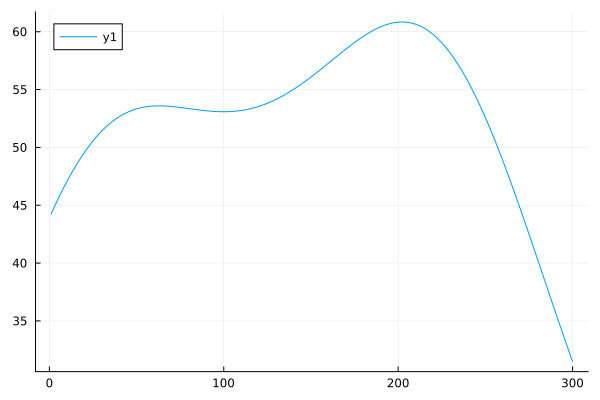

In [26]:
plot(mean.(iresult.posteriors[:g][end]),ribbon=var.(iresult.posteriors[:g][end]))

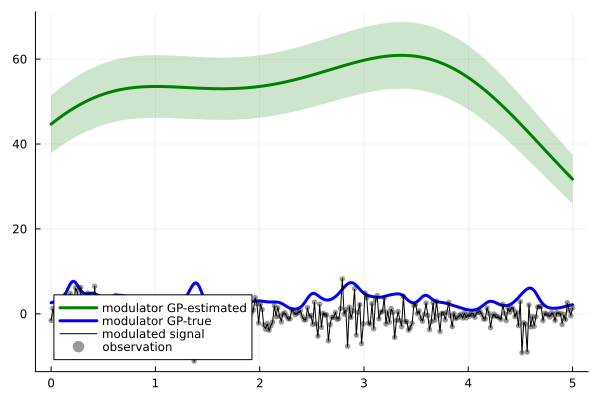

In [31]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
# plot!(time_range,-expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,exp.(f_test), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_train,y_true_state, label="modulated signal",color=:black)
scatter!(time_train,y_data, label="observation",color=:black,alpha=0.4,ms=3,legend=:bottomleft)
# plot!(time_range,mean.(iresult.posteriors[:g][end]),ribbon=var.(iresult.posteriors[:g][end]))

In [28]:
exp(mean(iresult.posteriors[:θ][end]))

1.0098521374471034

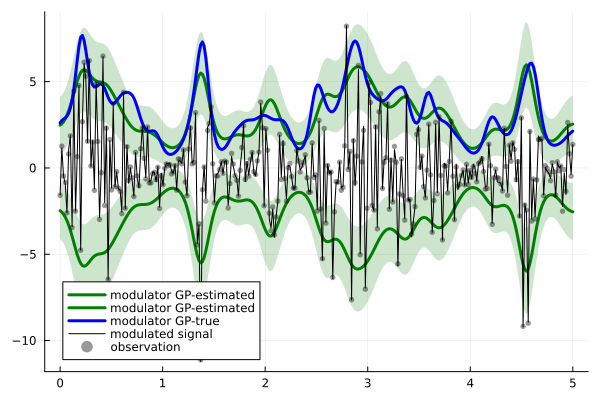

In [69]:





plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,-expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,exp.(f_test), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_train,y_true_state, label="modulated signal",color=:black)
scatter!(time_train,y_data, label="observation",color=:black,alpha=0.4,ms=3,legend=:bottomleft)


In [63]:
iresult.posteriors[:f][end].covariance_strategy

CovarianceMatrixStrategy{DeterministicInducingConditional{MersenneTwister}}(DeterministicInducingConditional{MersenneTwister}(90, MersenneTwister(1, (0, 2004, 1002, 338)), [0.3 0.29583460407751794 … 0.0 0.0; 0.29583460407751794 0.3 … 0.0 0.0; … ; 0.0 0.0 … 0.3 0.28368222584365554; 0.0 0.0 … 0.28368222584365554 0.3], [0.2645274313318668 0.28368222584361047 … 0.0 0.0; 0.23986381636653997 0.2645274313318668 … 0.0 0.0; … ; 0.0 0.0 … 0.23986381636658344 0.2115018640429918; 0.0 0.0 … 0.28368222584352654 0.264527431331811], [475.13502195177784 -588.1758994361937 … 0.006140127328022241 -0.001187528095641605; -588.1758994361937 731.038840999327 … -0.008157412869296266 0.0015776801444861823; … ; 0.006140127328022241 -0.008157412869296266 … 112347.12720629867 -24592.54122581621; -0.001187528095641605 0.0015776801444861823 … -24592.54122581621 5495.150138599959], [9.312998237530001 0.0 … 0.0 0.0; 0.0 10.819479071059137 … 0.0 0.0; … ; 0.0 0.0 … 11.418168428159012 0.0; 0.0 0.0 … 0.0 9.15994566603827

In [640]:
using ToeplitzMatrices
using FFTW

function makecircular(inputarray)
    nsamples = length(inputarray)
    N        = 2*(nsamples - 1)
    arr      = Array{eltype(inputarray)}(undef,N)
    @views arr[1:nsamples] = view(inputarray,:,1)
    tmp      = [@inbounds inputarray[nsamples - (i % nsamples) ] for i=nsamples+1:N]
    @views arr[nsamples+1:end] = view(tmp,:,1)
      
    return arr
end

function makecircularwith(inputarray,e)
    nsamples = length(inputarray)
    N        = 2*(nsamples - 1)
    arr      = Array{eltype(inputarray)}(undef,N)
    @views arr[1:nsamples] = view(inputarray,:,1)
    @views arr[nsamples+1:end] .= e
      
    return arr
end

function fastcompute(u,y)
    return real(sum(abs.(fft(y)).^2 ./ fft(u))/length(y)), real.(ifft(fft(y).*fft(u))), real.(ifft(fft(y)./fft(u))) 
end


# t = collect(0:0.1:1.0)
t = randn(10)
x = makecircular(t)
u = view(kernelmatrix(kernel(2.5),x),:,1)
# y = makecircularwith(randn(length(t)),0)
y = makecircular(randn(length(t)))
# @show y' *inv((Circulant(u)))*y
# @show sum(abs.(fft(y)).^2 ./ fft(u))/length(x)
fastcompute(u,y)

(-174.78180520353558, [-0.03690250399029349, 0.005361099298732765, -0.02575139563878533, 0.40795744587811344, 0.11791310672048014, 0.2663691036797119, 0.24243755758894922, 0.1803571346631299, 0.01801761126418486, 0.2993331237174917, 0.0180176112641848, 0.18035713466312986, 0.24243755758894922, 0.266369103679712, 0.1179131067204802, 0.40795744587811344, -0.025751395638785472, 0.0053610992987326665], [17.555045251499127, -34.50697245946222, 1.347438336077578, 30.297743821267318, -44.70366113724608, 42.95357958406672, -18.22151067452682, -4.177135044665328, 26.55926727968436, -16.54465543737897, 26.559267279684338, -4.177135044665255, -18.221510674526893, 42.95357958406676, -44.703661137246044, 30.29774382126724, 1.3474383360776552, -34.50697245946224])

In [13]:
using Plots

In [14]:
y' *inv((Circulant(u)))*y

-143.46789701715502

In [8]:
y[1:length(t)]'*cholinv(kernelmatrix(kernel(0.5),t,t))*y[1:length(t)]

1.9717129777514696e18

In [92]:
using FFTW, LinearAlgebra

In [2836]:
# shifted_index = fftshift(fftfreq(length(x))*length(x))

# make_circular!(ypadded)
Acircular = kernelmatrix(kernel(θ_gp),x,x) + 1e-8I;
uvect = Acircular[:,1];

In [2846]:
ffty = rfft(ypadded);
fftu = rfft(uvect)

@time ifft(ffty .* fftu)[1:nsamples]

  0.017762 seconds (31 allocations: 49.062 KiB)


1000-element Vector{ComplexF64}:
  -0.11065520146852031 - 7.116212428440154e-16im
   -0.1091593349524519 - 0.14819859320432208im
  -0.10467318181914743 - 0.2963137907801927im
   -0.0972008338937685 - 0.4442623412598123im
  -0.08674924656434632 - 0.5919611072652229im
  -0.07332811073896482 - 0.7393272790669363im
  -0.05694984677228604 - 0.8862785254938425im
 -0.037629584355845506 - 1.0327328884402298im
 -0.015385241410927848 - 1.1786090486068608im
  0.009762668278113779 - 1.3238264118383225im
  0.037790909967694464 - 1.4683050577556709im
    0.0686737149239616 - 1.6119660984708903im
   0.10238255570891125 - 1.754731467405131im
                       ⋮
   0.10238255570891533 + 1.7547314674051309im
   0.06867371492396024 + 1.611966098470889im
   0.03779090996769719 + 1.4683050577556687im
  0.009762668278116962 + 1.3238264118383218im
 -0.015385241410925574 + 1.1786090486068592im
  -0.03762958435584142 + 1.0327328884402274im
  -0.05694984677228786 + 0.8862785254938431im
  -0.073328110738964

In [2845]:
@time (Acircular[1:nsamples,1:nsamples])*ypadded[1:nsamples]

  0.006424 seconds (7 allocations: 7.645 MiB)


1000-element Vector{Float64}:
 -2.913109949454852
 -2.915887432401912
 -2.9182728291203315
 -2.9202627407817303
 -2.9218539111045883
 -2.9230430981160898
 -2.9238272395382485
 -2.924203347740067
 -2.924168536473067
 -2.9237200134098433
 -2.9228551399135787
 -2.9215713119256534
 -2.9198660636330174
  ⋮
  1.3912795205355866
  1.3642733082623375
  1.337580196506469
  1.3111999098073315
  1.2851320696606743
  1.259376276344438
  1.23393207240831
  1.2087989125564225
  1.183976220863267
  1.159463359117247
  1.135259630138748
  1.1113642627733462

In [118]:
f = x -> -log( abs(x[1]) + 1e-8 ) - 0.5*log(2π * (3. + 0.1 / x[1]^2))  - 1/2 * (2. / x[1] - 1.)^2 / (3. + 0.1 / x[1]^2)
derivative_f = x -> ForwardDiff.derivative(f, x)

#315 (generic function with 1 method)

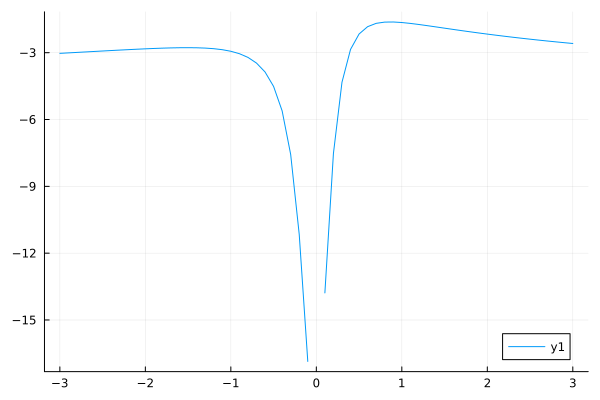

In [124]:
test = -3:0.1:3;
plot(test, f.(test))

In [120]:
find_zeros(derivative_f,-100,100)

Float64[]

In [127]:
res = optimize(f,[0.1], GradientDescent())


 * Status: success

 * Candidate solution
    Final objective value:     -1.993857e+01

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 5.35e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.13e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.66e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.31e-12 ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    19
    ∇f(x) calls:   19


In [128]:
res.minimizer

1-element Vector{Float64}:
 -0.017094082858806935

In [116]:
t(x) = (x[1] - 2) ^ 2

t (generic function with 1 method)

In [117]:
result = optimize(t,[100.],BFGS())

 * Status: success

 * Candidate solution
    Final objective value:     1.012392e-19

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 9.80e+01 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.90e+01 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.60e+03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.49e+22 ≰ 0.0e+00
    |g(x)|                 = 6.36e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3


In [107]:
result.minimizer

1-element Vector{Float64}:
 1.999999999681819